In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats
import statsmodels.stats.multicomp as mc
from scipy.stats import normaltest
from scipy.stats import shapiro
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
import os

# CMA aging Atlas: Subcutaneus adipose tissue
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Adipose (Brown) tissue data, Smart-seq2 assay in .h5ad format was used for further analysis.

## Importing and preprocessing data

In [2]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad('../Exp. 2_Tabula muris/Files/brown_adipose_tissue.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [3]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx')

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in tqdm(enumerate(barcode.index)):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]
2223it [00:07, 278.48it/s]


In [4]:
barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,n_genes,n_counts,louvain,leiden,...,organism_ontology_term_id,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000515_B008434_S10.mm10-plus-3-0,Multiple,18m,A10_B000515,granulocyte,facs,18_53_M,1425,2724.117432,10,12,...,NCBITaxon:10090,myeloid cell,Smart-seq2,normal,Mus musculus,male,brown adipose tissue,na,18 month-old stage,-0.518754
A10_B000800_B008432_S10.mm10-plus-3-0,Multiple,18m,A10_B000800,nan,facs,18_47_F,2077,3633.872559,2,0,...,NCBITaxon:10090,natural killer cell,Smart-seq2,normal,Mus musculus,female,brown adipose tissue,na,18 month-old stage,-0.037435
A11_B000515_B008434_S11.mm10-plus-3-0,Multiple,18m,A11_B000515,granulocyte,facs,18_53_M,1204,2622.148438,10,12,...,NCBITaxon:10090,myeloid cell,Smart-seq2,normal,Mus musculus,male,brown adipose tissue,na,18 month-old stage,-0.360875
A11_B000800_B008432_S11.mm10-plus-3-0,Multiple,18m,A11_B000800,nan,facs,18_47_F,1507,2950.103516,2,2,...,NCBITaxon:10090,B cell,Smart-seq2,normal,Mus musculus,female,brown adipose tissue,na,18 month-old stage,0.105653
A12_B000515_B008434_S12.mm10-plus-3-0,Multiple,18m,A12_B000515,nan,facs,18_53_M,1306,2982.207764,2,0,...,NCBITaxon:10090,B cell,Smart-seq2,normal,Mus musculus,male,brown adipose tissue,na,18 month-old stage,-0.113608


## CMA net score/cell type (fold over whole tissue)

In [5]:
# Checking n of mice 
print(list(barcode['mouse.id'].unique()))

['18_53_M', '18_47_F', '18_46_F', '18_45_M', '24_60_M', '24_61_M', '24_59_M', '24_58_M', '3_11_M', '3_9_M', '3_38_F', '3_39_F', '3_56_F', '3_10_M', '3_8_M']


**Mice n for Liver**
    - Young females: 3
    - Young males: 4
    - Old females: 2
    - Old males: 6

In [6]:
print(list(barcode.cell_type.unique()))

['myeloid cell', 'natural killer cell', 'B cell', 'T cell', 'endothelial cell', 'mesenchymal stem cell of adipose', 'epithelial cell']


In [7]:
# Generating new ages
for j in tqdm(barcode.index):    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    else:                
        barcode.loc[j, 'new_age'] = '18-24m'
        
for j in tqdm(barcode.index):    
    if barcode.loc[j, 'cell_type'] == 'mesenchymal stem cell of adipose':        
        barcode.loc[j, 'new_cell'] = 'Brown Adipose MSC'
    
    else:                
        barcode.loc[j, 'new_cell'] = barcode.loc[j, 'cell_type']


barcode.head()

100%|████████████████████████████████████████████████████████████████████████████| 2223/2223 [00:00<00:00, 5547.18it/s]


,FACS.selection,age,cell,free_annotation,method,mouse.id,n_genes,n_counts,louvain,leiden,...,assay,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age,new_cell
index,,,,,,,,,,,,,,,,,,,,,
A10_B000515_B008434_S10.mm10-plus-3-0,Multiple,18m,A10_B000515,granulocyte,facs,18_53_M,1425,2724.117432,10,12,...,Smart-seq2,normal,Mus musculus,male,brown adipose tissue,na,18 month-old stage,-0.518754,18-24m,myeloid cell
A10_B000800_B008432_S10.mm10-plus-3-0,Multiple,18m,A10_B000800,nan,facs,18_47_F,2077,3633.872559,2,0,...,Smart-seq2,normal,Mus musculus,female,brown adipose tissue,na,18 month-old stage,-0.037435,18-24m,natural killer cell
A11_B000515_B008434_S11.mm10-plus-3-0,Multiple,18m,A11_B000515,granulocyte,facs,18_53_M,1204,2622.148438,10,12,...,Smart-seq2,normal,Mus musculus,male,brown adipose tissue,na,18 month-old stage,-0.360875,18-24m,myeloid cell
A11_B000800_B008432_S11.mm10-plus-3-0,Multiple,18m,A11_B000800,nan,facs,18_47_F,1507,2950.103516,2,2,...,Smart-seq2,normal,Mus musculus,female,brown adipose tissue,na,18 month-old stage,0.105653,18-24m,B cell
A12_B000515_B008434_S12.mm10-plus-3-0,Multiple,18m,A12_B000515,nan,facs,18_53_M,1306,2982.207764,2,0,...,Smart-seq2,normal,Mus musculus,male,brown adipose tissue,na,18 month-old stage,-0.113608,18-24m,B cell


In [8]:
cells = ['Brown Adipose MSC']

In [9]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,n_genes,n_counts,louvain,leiden,...,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age,new_cell,net_score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000515_B008434_S10.mm10-plus-3-0,Multiple,18m,A10_B000515,granulocyte,facs,18_53_M,1425,2724.117432,10,12,...,normal,Mus musculus,male,brown adipose tissue,na,18 month-old stage,-0.518754,18-24m,myeloid cell,-0.543617
A10_B000800_B008432_S10.mm10-plus-3-0,Multiple,18m,A10_B000800,nan,facs,18_47_F,2077,3633.872559,2,0,...,normal,Mus musculus,female,brown adipose tissue,na,18 month-old stage,-0.037435,18-24m,natural killer cell,-0.062299
A11_B000515_B008434_S11.mm10-plus-3-0,Multiple,18m,A11_B000515,granulocyte,facs,18_53_M,1204,2622.148438,10,12,...,normal,Mus musculus,male,brown adipose tissue,na,18 month-old stage,-0.360875,18-24m,myeloid cell,-0.385738
A11_B000800_B008432_S11.mm10-plus-3-0,Multiple,18m,A11_B000800,nan,facs,18_47_F,1507,2950.103516,2,2,...,normal,Mus musculus,female,brown adipose tissue,na,18 month-old stage,0.105653,18-24m,B cell,0.080789
A12_B000515_B008434_S12.mm10-plus-3-0,Multiple,18m,A12_B000515,nan,facs,18_53_M,1306,2982.207764,2,0,...,normal,Mus musculus,male,brown adipose tissue,na,18 month-old stage,-0.113608,18-24m,B cell,-0.138472


### Cell types stats

In [10]:
# Function for testing normality using D'Agostino-Pearson of different cell types and ages
def normalidad (df, tipo, años):
    long = []
    cell = []
    age = []
    estadistica=[]
    pval=[]
    result=[]   
    
    for x in tipo:
        for y in años:
            mydata = df[(df['new_cell']== x) & (df['new_age']== y)]
            n = len(mydata.index)
            data = list(mydata.net_score)            
            stat, p = normaltest(data)
            long.append(n)
            cell.append(x)
            age.append(y)
            estadistica.append(stat)
            pval.append(p)
            if p > 0.05:
                result.append("Normal")
            else:
                result.append("Not normal")    
    df_norm = pd.DataFrame({"Cell": cell, "Age": age, "n": long, "Stat":estadistica, "p value": pval, "Result":result})
    return(df_norm)

In [11]:
normalidad(barcode, tipo=cells, años=['3m', '18-24m'])

,Cell,Age,n,Stat,p value,Result
0,Brown Adipose MSC,3m,82,1.608937,0.447326,Normal
1,Brown Adipose MSC,18-24m,123,0.803168,0.669259,Normal


In [12]:
# Calculating T test for the cells of interest
for i in cells:
    # First Levene test for equal variances
    group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
    group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])
    print('Levene test for {}'.format(i.title()))
    stat, p = stats.levene(group3, group18_24)
    print("Levene's test pval for {} = {}".format(i.title(), p))
    
    # T test
    if p < 0.05:
        stat2, p2 = stats.ttest_ind(group3, group18_24, equal_var=False)
        print('T test for {}, with no equal var.'.format(i))
        print("T test pval = " + str(p2))
        print('\n')
        
    else:
        stat2, p2 = stats.ttest_ind(group3, group18_24, equal_var=True)
        print('T test for {}, assuming equal var.'.format(i))
        print("T test pval = " + str(p2))
        print('\n')

Levene test for Brown Adipose Msc
Levene's test pval for Brown Adipose Msc = 0.23583588330895602
T test for Brown Adipose MSC, assuming equal var.
T test pval = 0.41775955921631913




C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\1950987232.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\1950987232.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])


### Net score graph

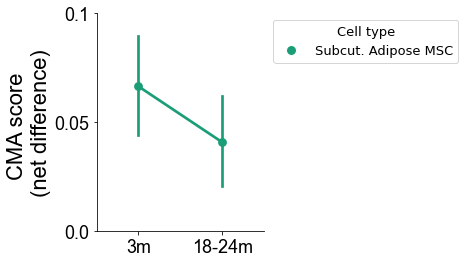

In [14]:
# CMA net score by cell type
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.pointplot(x='new_age', y='net_score', data=barcode, hue='new_cell', order=["3m", "18-24m"], 
              hue_order=cells, palette="Dark2", ci=68)
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
plt.xlabel('')
plt.ylim(0.0, 0.10) 
ax.set_yticks([0.0, 0.05, 0.10])
ax.set_yticklabels([0.0, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})

# Legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='#1b9e77', label='Subcut. Adipose MSC', 
                         markersize=10)]

plt.legend(handles=legend_elements, bbox_to_anchor = (2.2, 1), facecolor='white', title="Cell type", title_fontsize = "13", 
           fontsize=13)
                          
plt.savefig('../Khawaja_et_al_outputs/Adipose/BAd_nscorrect.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [15]:
# Extracting raw values for pointplot graphic
long = []
celula = []
age = []
mean=[]
sem=[]

for x in cells:
    for y in ['3m', '18-24m']:
        n = len(barcode[barcode['new_cell']== x][barcode['new_age']== y].index)
        m = np.mean(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score'])
        s = stats.sem(np.array(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score']))
        
        long.append(n)
        celula.append(x)
        age.append(y)
        mean.append(m)
        sem.append(s)
        
df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "n": long, "Mean":mean, "SEM": sem})
df_raw

C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\1532967860.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['new_cell']== x][barcode['new_age']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\1532967860.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\1532967860.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(np.array(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score']))


,Cell_type,Age,n,Mean,SEM
0,Brown Adipose MSC,3m,82,0.066442,0.022886
1,Brown Adipose MSC,18-24m,123,0.040779,0.020809


In [17]:
df_raw.to_excel('../Khawaja_et_al_outputs/Adipose/BAd_Raw_data.xlsx', 'Netsc', index=False)

## CMA net score/cell type & sex  (fold over whole tissue)

### Stats

In [18]:
# Calculating n of cells per cell type, sex and age
for i in cells:
    print(i.title() + " length:" + str(len(barcode[barcode["new_cell"]==i].index)))
    print(barcode[barcode["new_cell"]==i].value_counts(["sex", "new_age"]))
    print("\n")

Brown Adipose Msc length:205
sex     new_age
male    18-24m     120
        3m          57
female  3m          25
        18-24m       3
dtype: int64




In [19]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode[barcode['new_cell']==i].reset_index()    
    
    # 2-way Anova
    model = ols('net_score ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['net_score'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Brown Adipose Msc 2-way Anova

                      df    sum_sq   mean_sq         F    PR(>F)
C(new_age)           1.0  0.032403  0.032403  0.654565  0.419442
C(sex)               1.0  0.007853  0.007853  0.158634  0.690840
C(new_age):C(sex)    1.0  0.019032  0.019032  0.384466  0.535925
Residual           201.0  9.950089  0.049503       NaN       NaN


Brown Adipose Msc Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat   pval  pval_corr reject
-------------------------------------------------------------
18-24m & female 18-24m & male  0.6973 0.4869       1.0  False
18-24m & female   3m & female  0.4128 0.6832       1.0  False
18-24m & female     3m & male  0.6261 0.5337       1.0  False
  18-24m & male   3m & female -0.6337 0.5273       1.0  False
  18-24m & male     3m & male -0.7315 0.4654       1.0  False
    3m & female     3m & male   0.142 0.8875       1.0  False
--------------

### Graphs

#### MS cells of brown adipose tissue

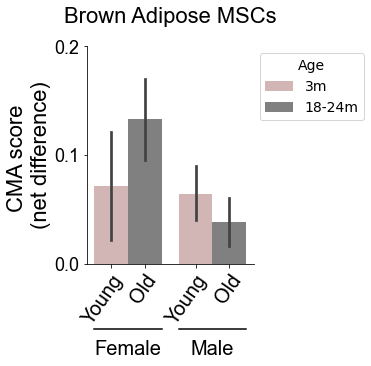

In [25]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.new_cell==cells[0]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(0.0, 0.20)
ax.set_yticks([0.0, 0.10, 0.20])
ax.set_yticklabels([0.0, 0.10, 0.20], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Brown Adipose MSCs', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khawaja_et_al_outputs/Adipose/BAd_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [22]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])
                s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khawaja_et_al_outputs/Adipose/BAd_Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="Nsbysex", index=False)
    return(df_raw)

In [23]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\3904320233.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\3904320233.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\3904320233.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])


,Cell_type,Age,Sex,n,Mean,SEM
0,Brown Adipose MSC,3m,female,25,0.071379,0.050339
1,Brown Adipose MSC,3m,male,57,0.064277,0.024765
2,Brown Adipose MSC,18-24m,female,3,0.132747,0.056259
3,Brown Adipose MSC,18-24m,male,120,0.038480,0.021258


## CMA net score/cell type & sex (fold over each cell type young)

In [24]:
# Calculation of net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['new_cell'])):
    
    µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
    
    for cell_index in barcode[barcode['new_cell'] == maj_cell].index:
    
        barcode.loc[cell_index, 'celltype_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\2122786486.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
 14%|████████████                                                                        | 1/7 [00:00<00:00,  8.17it/s]C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\2122786486.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 13.96it/s]


,FACS.selection,age,cell,free_annotation,method,mouse.id,n_genes,n_counts,louvain,leiden,...,organism,sex,tissue,ethnicity,development_stage,score,new_age,new_cell,net_score,celltype_ns
index,,,,,,,,,,,,,,,,,,,,,
A10_B000515_B008434_S10.mm10-plus-3-0,Multiple,18m,A10_B000515,granulocyte,facs,18_53_M,1425,2724.117432,10,12,...,Mus musculus,male,brown adipose tissue,na,18 month-old stage,-0.518754,18-24m,myeloid cell,-0.543617,-0.531753
A10_B000800_B008432_S10.mm10-plus-3-0,Multiple,18m,A10_B000800,nan,facs,18_47_F,2077,3633.872559,2,0,...,Mus musculus,female,brown adipose tissue,na,18 month-old stage,-0.037435,18-24m,natural killer cell,-0.062299,-0.086320
A11_B000515_B008434_S11.mm10-plus-3-0,Multiple,18m,A11_B000515,granulocyte,facs,18_53_M,1204,2622.148438,10,12,...,Mus musculus,male,brown adipose tissue,na,18 month-old stage,-0.360875,18-24m,myeloid cell,-0.385738,-0.373875
A11_B000800_B008432_S11.mm10-plus-3-0,Multiple,18m,A11_B000800,nan,facs,18_47_F,1507,2950.103516,2,2,...,Mus musculus,female,brown adipose tissue,na,18 month-old stage,0.105653,18-24m,B cell,0.080789,0.116822
A12_B000515_B008434_S12.mm10-plus-3-0,Multiple,18m,A12_B000515,nan,facs,18_53_M,1306,2982.207764,2,0,...,Mus musculus,male,brown adipose tissue,na,18 month-old stage,-0.113608,18-24m,B cell,-0.138472,-0.102439


### Graphs

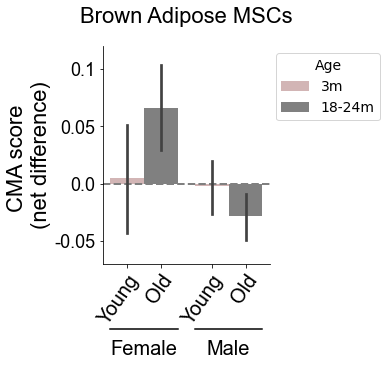

In [28]:
# Figure MSCs
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell==cells[0]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.07, 0.12)
ax.set_yticks([-0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Brown Adipose MSCs', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)


plt.savefig('../Khawaja_et_al_outputs/Adipose/BAd_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [29]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
                s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khawaja_et_al_outputs/Adipose/BAd_Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="CellNsbysex", index=False)
    return(df_raw)

In [30]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\2420084603.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\2420084603.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\2420084603.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])


,Cell_type,Age,Sex,n,Mean,SEM
0,Brown Adipose MSC,3m,female,25,0.004936,0.050339
1,Brown Adipose MSC,3m,male,57,-0.002165,0.024765
2,Brown Adipose MSC,18-24m,female,3,0.066305,0.056259
3,Brown Adipose MSC,18-24m,male,120,-0.027962,0.021258


## CMA network heatmaps by cell type & sex

In [31]:
# Load matrix reordered
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx', 'reordered')

# Removing EEF1A1 and RAC1 because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

In [32]:
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((16, 4))
    
    #Find cell indices for each condition
    female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
    female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    with pd.ExcelWriter("../Khawaja_et_al_outputs/Adipose/BAd_Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_m.to_excel(writer, sheet_name=cellpop[:3]+'_heat', index=True)
        
    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(6,6))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5)
    plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

    plt.yticks(np.arange(16), model_matrix['Gene name'], fontsize=16, **hfont)

    plt.ylim(15.5, -0.5)

    plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
    plt.title(cellpop, fontdict={'family':'Arial', 'size': 22}, y=1.05)

    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans = ax.get_yaxis_transform()
    trans2 = ax.get_xaxis_transform()
    ax.annotate('Effectors', xy=(-1.5, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                color='k', size=16, **hfont)
    ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)

    ax.annotate('Pos. regulators', xy=(-1.5, 4.75), xycoords=trans, ha='left', rotation=90, va="top", 
                color='green', size=16, **hfont)
    ax.plot([-1.25,-1.25],[4.75, 10.25], color="k", transform=trans, clip_on=False)

    ax.annotate('Neg. regulators', xy=(-1.5, 10.5), xycoords=trans, ha='left', rotation=90, va="top", 
                color='red', size=16, **hfont)
    ax.plot([-1.25,-1.25],[11, 15.25], color="k", transform=trans, clip_on=False)

    ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

    ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
    
    plt.savefig('../Khawaja_et_al_outputs/Adipose/BAd_heat.png',bbox_inches='tight', dpi=300)
    
    plt.show()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\3294934471.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\3294934471.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\3294934471.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\3294934471.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['new_cell'] == c

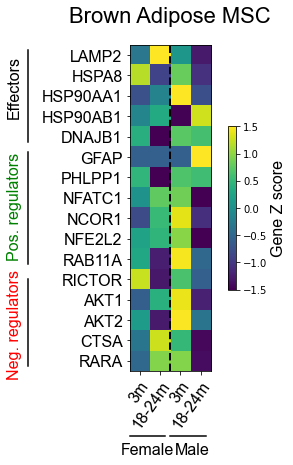

In [33]:
for i in cells:
    sex_heatmaps(cellpop=i)

## Ridge plots for L2 and L1

In [34]:
# Codes for L2 and L1
lys = ['ENSMUSG00000016534', 'ENSMUSG00000031447']

In [35]:
# Selecting only L2 and L1 from adata
adata_lys = adata[:, lys]
barcode_lys = adata.obs.copy()

# Calculating the Z score for L2 & L1
lys_zs = adata_lys.copy().X.todense()

for i in tqdm(np.arange(lys_zs.shape[1])):
    
    µ = np.mean(lys_zs[:, i])
    sd = np.std(lys_zs[:, i])
    
    lys_zs[:, i] = (lys_zs[:, i] - µ)/sd
    
# Converting lys_zs.X to a pandas df
df_lys = pd.DataFrame(lys_zs.tolist())
df_lys.rename(columns={0:"L2", 1:'L1'}, inplace=True)

# Generating barcode df and appending L2 column
barcode_lys = barcode_lys.reset_index()
barcode_lys = pd.concat([barcode_lys, df_lys], axis=1)
barcode_lys = barcode_lys [['index', 'cell', 'cell_type', 'sex', 'age', 'L2', 'L1']]

barcode_lys.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 128.09it/s]


,index,cell,cell_type,sex,age,L2,L1
0,A10_B000515_B008434_S10.mm10-plus-3-0,A10_B000515,myeloid cell,male,18m,0.893311,-1.166821
1,A10_B000800_B008432_S10.mm10-plus-3-0,A10_B000800,natural killer cell,female,18m,-0.752912,0.622003
2,A11_B000515_B008434_S11.mm10-plus-3-0,A11_B000515,myeloid cell,male,18m,0.580347,0.520942
3,A11_B000800_B008432_S11.mm10-plus-3-0,A11_B000800,B cell,female,18m,-0.752912,0.983488
4,A12_B000515_B008434_S12.mm10-plus-3-0,A12_B000515,B cell,male,18m,-0.752912,0.411565


In [36]:
# Generating new ages
for j in barcode_lys.index:    
    if barcode_lys.loc[j, 'age'] == '3m':        
        barcode_lys.loc[j, 'new_age'] = '3m'

    else:                
        barcode_lys.loc[j, 'new_age'] = '18-24m'

# Generating new cell types combining some of them
for j in tqdm(barcode_lys.index):    
    if barcode_lys.loc[j, 'cell_type'] == 'mesenchymal stem cell of adipose':        
        barcode_lys.loc[j, 'new_cell'] = 'Brown Adipose MSC'
    
    else:                
        barcode_lys.loc[j, 'new_cell'] = barcode_lys.loc[j, 'cell_type']
     
barcode_lys.head()

100%|████████████████████████████████████████████████████████████████████████████| 2223/2223 [00:00<00:00, 6012.98it/s]


,index,cell,cell_type,sex,age,L2,L1,new_age,new_cell
0,A10_B000515_B008434_S10.mm10-plus-3-0,A10_B000515,myeloid cell,male,18m,0.893311,-1.166821,18-24m,myeloid cell
1,A10_B000800_B008432_S10.mm10-plus-3-0,A10_B000800,natural killer cell,female,18m,-0.752912,0.622003,18-24m,natural killer cell
2,A11_B000515_B008434_S11.mm10-plus-3-0,A11_B000515,myeloid cell,male,18m,0.580347,0.520942,18-24m,myeloid cell
3,A11_B000800_B008432_S11.mm10-plus-3-0,A11_B000800,B cell,female,18m,-0.752912,0.983488,18-24m,B cell
4,A12_B000515_B008434_S12.mm10-plus-3-0,A12_B000515,B cell,male,18m,-0.752912,0.411565,18-24m,B cell


In [37]:
# Reducing df only to cells of interest
barcode_lys = barcode_lys[barcode_lys['new_cell'].isin(cells)]
print(barcode_lys.new_cell.unique())
barcode_lys.head()

['Brown Adipose MSC']


,index,cell,cell_type,sex,age,L2,L1,new_age,new_cell
15,A1_B000515_B008434_S1.mm10-plus-3-0,A1_B000515,mesenchymal stem cell of adipose,male,18m,0.258724,0.089344,18-24m,Brown Adipose MSC
37,B4_B000515_B008434_S28.mm10-plus-3-0,B4_B000515,mesenchymal stem cell of adipose,male,18m,-0.752912,0.858238,18-24m,Brown Adipose MSC
59,C8_B000515_B008434_S56.mm10-plus-3-0,C8_B000515,mesenchymal stem cell of adipose,male,18m,1.101096,0.262232,18-24m,Brown Adipose MSC
78,D4_B000515_B008434_S76.mm10-plus-3-0,D4_B000515,mesenchymal stem cell of adipose,male,18m,0.957918,0.790451,18-24m,Brown Adipose MSC
95,E1_B000515_B008434_S97.mm10-plus-3-0,E1_B000515,mesenchymal stem cell of adipose,male,18m,0.891397,0.776652,18-24m,Brown Adipose MSC


### Graphs

#### Lamp2 female

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layo

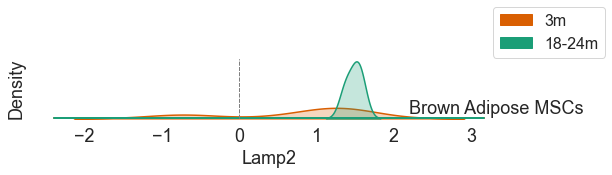

In [43]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.2, y=0.25, s='Brown Adipose MSCs', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.3, 2), facecolor='white', fontsize=16)

plt.savefig('../Khawaja_et_al_outputs/Adipose/BAdL2_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp2 male

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layo

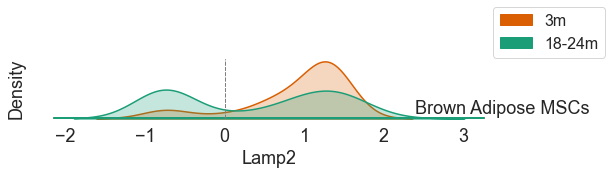

In [48]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.4, y=0.08, s='Brown Adipose MSCs', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.3, 2), facecolor='white', fontsize=16)

plt.savefig('../Khawaja_et_al_outputs/Adipose/BAdL2_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp1 female

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layo

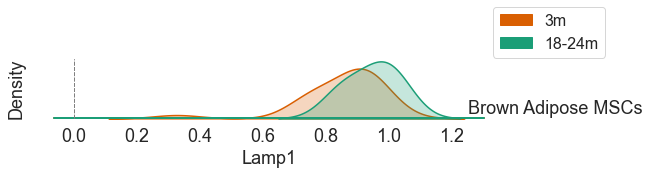

In [51]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=1.25, y=0.3, s='Brown Adipose MSCs', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.3, 2), facecolor='white', fontsize=16)

plt.savefig('../Khawaja_et_al_outputs/Adipose/BAdL1_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp1 male

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layo

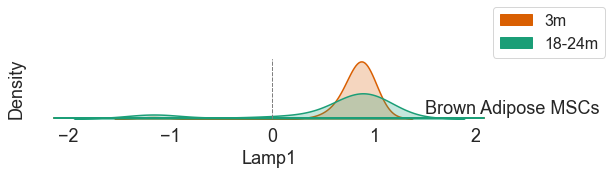

In [54]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=1.5, y=0.2, s='Brown Adipose MSCs', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.3, 2), facecolor='white', fontsize=16)

plt.savefig('../Khawaja_et_al_outputs/Adipose/BAdL1_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

## L2 Bar graphs

### Stats

In [55]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode_lys[barcode_lys['new_cell']==i].reset_index(drop=True)    
    
    # 2-way Anova
    model = ols('L2 ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['L2'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Brown Adipose Msc 2-way Anova

                      df      sum_sq    mean_sq          F    PR(>F)
C(new_age)           1.0   11.288180  11.288180  14.231035  0.000213
C(sex)               1.0    0.013110   0.013110   0.016527  0.897835
C(new_age):C(sex)    1.0    4.159863   4.159863   5.244349  0.023056
Residual           201.0  159.434946   0.793209        NaN       NaN


Brown Adipose Msc Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat   pval  pval_corr reject
-------------------------------------------------------------
18-24m & female 18-24m & male  1.9585 0.0525    0.3148  False
18-24m & female   3m & female  1.4225 0.1668       1.0  False
18-24m & female     3m & male  1.5216 0.1335    0.8012  False
  18-24m & male   3m & female -1.8426 0.0675    0.4047  False
  18-24m & male     3m & male -3.8474 0.0002     0.001   True
    3m & female     3m & male -0.9237 0.3584       1.0  

### Graphs

In [56]:
sns.reset_defaults()

#### Subcut. Adipose MSCs

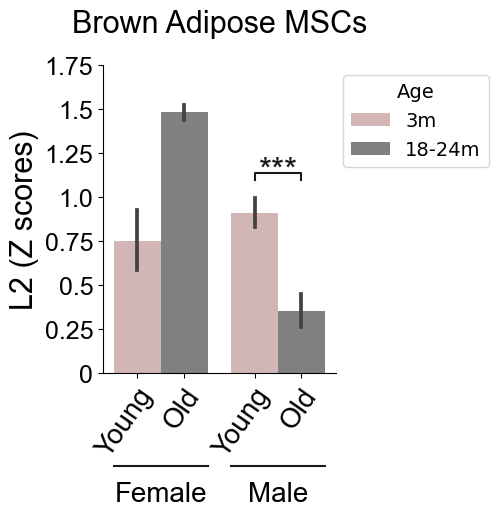

In [63]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.new_cell==cells[0]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(0, 1.75)
ax.set_yticks([0, 0.25, 0.50, 0.75, 1.0, 1.25, 1.50, 1.75])
ax.set_yticklabels([0, 0.25, 0.50, 0.75, 1.0, 1.25, 1.50, 1.75], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Brown Adipose MSCs', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 1.10 , 0.04, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "***", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khawaja_et_al_outputs/Adipose/BAd_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [64]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y].index)
                m = np.mean(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])
                s = stats.sem(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khawaja_et_al_outputs/Adipose/BAd_Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="L2bysex", index=False)
    return(df_raw)

In [65]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\2543005804.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\2543005804.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_18952\2543005804.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])


,Cell_type,Age,Sex,n,Mean,SEM
0,Brown Adipose MSC,3m,female,25,0.749967,0.175516
1,Brown Adipose MSC,3m,male,57,0.910312,0.085644
2,Brown Adipose MSC,18-24m,female,3,1.483235,0.059725
3,Brown Adipose MSC,18-24m,male,120,0.354913,0.090716
